<a href="https://colab.research.google.com/github/heosuab/Face_detection_and_mosaic/blob/main/Face_detection_Mosaic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install face_recognition opencv-python matplotlib
import cv2, os
import face_recognition as fr
from IPython.display import Image, display
from matplotlib import pyplot as plt

     |████████████████████████████████| 100.2MB 68kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=5a912c07c1649519020557f52876ab867aa0040fdbecd16a9acefcda441060e0
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [ ]:
import math
from sklearn import neighbors
import os
import os.path
import pickle
from pathlib import Path
from PIL import Image, ImageDraw, ImageFilter
import face_recognition as fr
from  face_recognition.face_recognition_cli import image_files_in_folder

ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg'}

In [ ]:
#    Trains a k-nearest neighbors classifier for face recognition.

X = []
y = []
train_dir = '/content/drive/MyDrive/Colab_Notebooks/train_dir'
model_path = '/content/drive/MyDrive/Colab_Notebooks/model_save'
model_save_path = Path(model_path) / 'model_save.pkl'
n_neighbors = None
knn_algo = 'ball_tree'
verbose = False
count = 0
# Loop through each person in the training set
for class_dir in os.listdir(train_dir):
   if not os.path.isdir(os.path.join(train_dir, class_dir)):
       continue
     # Loop through each training image for the current person
   for img_path in image_files_in_folder(os.path.join(train_dir, class_dir)):
        count+=1
        image = fr.load_image_file(img_path)
        face_bounding_boxes = fr.face_locations(image)

        if len(face_bounding_boxes) != 1:
           # If there are no people (or too many people) in a training image, skip the image.
           if verbose:
                print("Image {} not suitable for training: {}".format(img_path, "Didn't find a face" if len(face_bounding_boxes) < 1 else "Found more than one face"))
        else:
           # Add face encoding for current image to the training set
            X.append(fr.face_encodings(image, known_face_locations=face_bounding_boxes)[0])
            y.append(class_dir)
 # Determine how many neighbors to use for weighting in the KNN classifier
if n_neighbors is None:
    n_neighbors = int(round(math.sqrt(len(X))))+7
    print(len(X), n_neighbors)
    if verbose:
        print("Chose n_neighbors automatically:", n_neighbors)
 # Create and train the KNN classifier
knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')
knn_clf.fit(X, y)
# Save the trained KNN classifier
if model_save_path is not None:
   with open(model_save_path, 'wb') as f:
       pickle.dump(knn_clf, f)

83 16


In [ ]:
#    Recognizes faces in given image using a trained KNN classifier

img_path = '/content/drive/MyDrive/Colab_Notebooks/test_dir/ten5.jpg'
knn_clf = None
model_path = '/content/drive/MyDrive/Colab_Notebooks/model_save/model_save.pkl'
distance_threshold=0.32

if not os.path.isfile(img_path) or os.path.splitext(img_path)[1][1:] not in ALLOWED_EXTENSIONS:
    raise Exception("Invalid image path: {}".format(img_path))

# Load a trained KNN model (if one was passed in)
if knn_clf is None:
    with open(model_path, 'rb') as f:
            knn_clf = pickle.load(f)

# Load image file and find face locations
X_img = fr.load_image_file(img_path)
X_face_locations = fr.face_locations(X_img)

if len(X_face_locations) == 0:
   predictions = {}
else:
  # Find encodings for faces in the test iamge
  faces_encodings = fr.face_encodings(X_img, known_face_locations=X_face_locations)

  # Use the KNN model to find the best matches for the test face
  closest_distances = knn_clf.kneighbors(faces_encodings, n_neighbors=1)
  are_matches = [closest_distances[0][i][0] <= distance_threshold for i in range(len(X_face_locations))]
  predictions = set()
  for pred, loc, rec in zip(knn_clf.predict(faces_encodings), X_face_locations, are_matches):
    print(loc, pred)
    if rec:
      predictions_df = (pred, loc)
      predictions.add(predictions_df)

    else:
      predictions_df = ('unknown', loc)
      predictions.add(predictions_df)


(764, 674, 827, 612) IU
(1261, 255, 1350, 165) KSH
(68, 282, 175, 175) KSH
(544, 554, 634, 464) KSH
(66, 554, 156, 464) KSH
(1017, 237, 1092, 162) YA
(792, 246, 854, 183) YA
(514, 135, 604, 46) YA
(1249, 710, 1324, 635) IU
(1009, 129, 1084, 55) YA
(758, 529, 820, 467) KSH
(773, 414, 863, 325) YA
(82, 425, 211, 296) KSH
(516, 688, 578, 626) IU
(305, 116, 395, 26) KSH
(1286, 127, 1394, 20) KSH
(311, 712, 440, 583) IU
(46, 703, 136, 613) YA
(320, 403, 395, 328) IU
(1231, 394, 1320, 305) IU
(749, 139, 856, 32) IU
(1009, 419, 1084, 345) IU
(288, 239, 350, 176) KSH
(1266, 527, 1341, 453) IU
(1028, 712, 1157, 583) KSH
(304, 536, 378, 461) KSH
(1023, 569, 1131, 462) IU
(516, 377, 568, 325) IU
(528, 245, 602, 171) KSH
(66, 106, 156, 16) IU


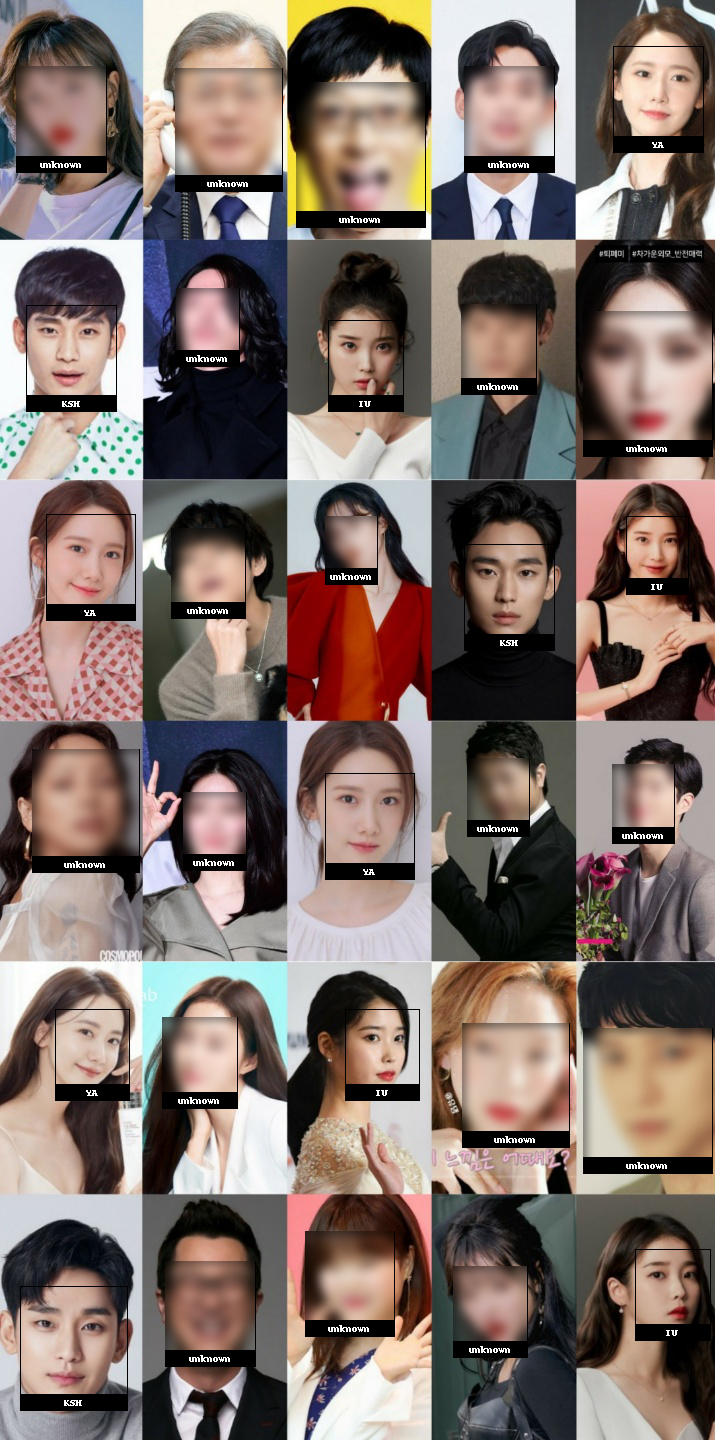

In [ ]:
pil_image = Image.open(img_path).convert("RGB")
draw = ImageDraw.Draw(pil_image)

for name, (top, right, bottom, left) in predictions:
    # Draw a box around the face using the Pillow module
    draw.rectangle(((left, top), (right, bottom)), outline=(0, 0, 0))
    if name=='unknown':
      crop_image = pil_image.crop((left, top, right, bottom))
      blur_image = crop_image.filter(ImageFilter.GaussianBlur(radius=5))
      pil_image.paste(blur_image, (left, top))

    # There's a bug in Pillow where it blows up with non-UTF-8 text
    # when using the default bitmap font
    name = name.encode("UTF-8")

     # Draw a label with a name below the face
    text_width, text_height = draw.textsize(name)
    draw.rectangle(((left, bottom + text_height + 5), (right, bottom)), fill=(0, 0, 0), outline=(0, 0,0))
    draw.text(((left + right)/2 - text_width/2, bottom + text_height - 8), name, fill=(255, 255, 255, 255))

# Remove the drawing library from memory as per the Pillow docs
del draw

# Display the resulting image
display(pil_image)

pil_image.save('final_image.jpg')

In [ ]:
 closest_distances

(array([[0.54002253],
        [0.54005271],
        [0.61704248],
        [0.1716255 ],
        [0.32666889],
        [0.32045732],
        [0.40891235],
        [0.18682328],
        [0.24072233],
        [0.29841085],
        [0.48006022],
        [0.13617119],
        [0.59549468],
        [0.29315898],
        [0.24793715],
        [0.25746406],
        [0.41347531],
        [0.18313551],
        [0.28316551],
        [0.39180801],
        [0.39355045],
        [0.24839873],
        [0.52733924],
        [0.37293344],
        [0.4209468 ],
        [0.47196741],
        [0.35222437],
        [0.41711127],
        [0.4131435 ],
        [0.42553996]]), array([[47],
        [12],
        [12],
        [10],
        [21],
        [52],
        [41],
        [60],
        [29],
        [70],
        [17],
        [60],
        [12],
        [37],
        [16],
        [ 0],
        [31],
        [58],
        [37],
        [53],
        [34],
        [47],
        [ 9],
        [28],
   

In [ ]:
np.min(closest_distances, axis=1)

NameError: ignored

In [ ]:
np.mean(closest_distances, axis=1)

In [ ]:
path_def = '/content/drive/MyDrive/Colab_Notebooks/sua_test_dir'

for filename in os.listdir(path_def):
  file_path=os.path.join(path_def, filename)
  print(file_path)
  print(filename)